In [1]:
# Notebook 1 of the LSST Crowded Fields pipeline

# Loop over decaps fields  :
#    read in the decaps single-epoch catalog
#    use the zeropoint from the calibration files 
#    'clean' using the decaps flags 
#
#    read in the lsst src catalog
#    'clean' using the lsst masks 
#    - no need to use the calexp files 



In [2]:
# necessary imports 
import matplotlib.pyplot as plt
from astropy.table import Table
import os
import numpy as np
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=13, usetex=True)
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from scipy.stats import binned_statistic as bs
from itertools import product
import urllib.request
from astroML.stats._point_statistics import sigmaG

In [10]:
# Use the calibrated pipelinme 
zps = fits.open('../raw_data/decaps_catalogs/zps.fits')

# look for the headers that contain zeropoints ... 
zp_hdu = []
for i in range(len(zps[:])):
    values = [x for x in zps[i].header.values()] 
    if 'zp' in values:
        zp_hdu.append(i)
    
# Combine all calibrated zeropoints buried in 
# that FITS file ...
zps_table = Table(zps[zp_hdu[0]].data)

for j in zp_hdu[1:]:
    t = Table(zps[j].data)
    zps_table = vstack([zps_table, t])

In [3]:
# Use the image database 
image_database = '../raw_data/decaps_catalogs/imdb.fits'
imdb_hdu = fits.open(image_database)
imdb = Table(imdb_hdu[1].data)

In [22]:
# Loop over visits ...

def read_decaps(visit, imdb, save_tables=True):
    #####################################################################################
    ################################### use all DECAPS info  ############################
    #####################################################################################
    # read in the DECAPS single-epoch catalog ...
    singleDir = '../raw_data/decaps_catalogs/single_epoch/'
    cat_name = imdb[imdb['expnum'] == visit]['catfname'].data[0]
    file_name  = singleDir + cat_name
    print('The single-band catalog name corresponding to visit %d is %s' %(visit, cat_name))

    # the cat name is based on the image name ... 
    #image_name = 'c4d_170122_055542_ooi_g'
    #cat_name = image_name + '_v1.cat.fits'
    singleDir = '../raw_data/decaps_catalogs/single_epoch/'
    file_name  = singleDir + cat_name

    # check if the catalog already exists
    if cat_name not in  os.listdir(singleDir) : 
        print('Downloading the catalog...')# if not, download it ...
        url = 'https://faun.rc.fas.harvard.edu/decaps/release/cat/' + cat_name
        urllib.request.urlretrieve(url, file_name)

    #open the decaps catalog ...
    decaps_hdu = fits.open(file_name)

    # make a dictionary of ccdnumber vs hduposition
    ccd_name_dict = {}
    cat_decaps_dict = {}
    for i in range(1,len(decaps_hdu[:])) : 
        if 'IMAGE' in decaps_hdu[i].header['XTENSION'] :
            ccdnum = decaps_hdu[i].header['CCDNUM']
            detpos = decaps_hdu[i].header['DETPOS']
            ccd_name_dict[ccdnum] = detpos
            cat_decaps_dict[ccdnum] = int(i+2)

    # obtain the calibrated decaps zeropoint ...
    #mjd_obs = decaps_hdu[0].header['MJD-OBS']
    #m = zps_table['mjd_obs'] == mjd_obs
    #decaps_zeropoint = zps_table['zp'][m].data[0]

    # use the decaps single-epoch zeropoint 
    decaps_zeropoint = decaps_hdu[0].header['MAGZERO']  
    print('decaps calibrated zeropoint is ', decaps_zeropoint)

    # Make a Table from the ccd dictionary 
    dict_ccd = {}
    dict_ccd['ccdnum'] = ccd_name_dict.keys()
    dict_ccd['ccdname'] = ccd_name_dict.values()
    dict_ccd['hdupos'] = cat_decaps_dict.values()

    a = list(dict_ccd['ccdnum'])
    b = list(dict_ccd['ccdname'])
    c = list(dict_ccd['hdupos'])

    t = Table([a, b, c], names=('ccdnum', 'ccdname', 'hdupos'))

    # read in all the info from the decaps single-epoch catalog
    arr = { 'decaps_mag':[],'decaps_magerr':[]} #,'decaps_ra':[],
           #'decaps_dec':[], 'decaps_flags':[]}
    decaps_stack = Table(arr, names = ('decaps_mag', 'decaps_magerr'))#,
                              #          'decaps_ra', 'decaps_dec', 
                              #          'decaps_flags', 'decaps_x',
                              #        'decaps_y', 'decaps_ccd'),
                              #  dtype = ('f8', 'f8','f8', 'f8', 'i8'))

    # we don't want to use ccd31 because of unstable amplifier ...
    ccds = np.array(list(ccd_name_dict.keys()))
    ccd_numbers = ccds[ccds != 31 ]
    print('Reading DECAPS src catalogs looping over CCDs')
    N_total_sources = 0
    N_removed_flags = 0
    N_removed_neg_flux=0
    N_removed_low_SN=0
    N_removed_total=0
    for ccd_number  in ccd_numbers :
        #print('Processing ccd ', ccd_number)
        ccdnum = str(ccd_number).zfill(2)

        # read in the DECAPS catalog from the HDU 
        hdupos = cat_decaps_dict[ccd_number]
        ccd_data =  Table(decaps_hdu[hdupos].data) 
        flux = ccd_data['flux'].data
        fluxErr = ccd_data['dflux'].data
        flags = ccd_data['flags'].data
        N_total_sources += len(flags)
        
        # only consider positive fluxes... 
        mask_neg_fluxes = flux > 0
        N_removed_neg_flux += np.sum(~mask_neg_fluxes)
        
        # mask low signal to noise sources .... 
        mask_low_sn = (flux / fluxErr ) > 5 
        N_removed_low_SN += np.sum(~mask_low_sn)
        
        # Using the decaps flags information, clean the DECAPS data 
        mask_decaps_filter = 2**1+  2**3+  2**4+  2**5+  2**6+  2**8+  2**20+  2**22
        mask_bad_flags = np.bitwise_not(flags & mask_decaps_filter > 0)
        N_removed_flags += np.sum(~mask_bad_flags)
        
        # combine the flags....
        mask_total = mask_neg_fluxes * mask_low_sn * mask_bad_flags
        N_removed_total += np.sum(~mask_total) 
    
        fluxG = flux[mask_total]
        fluxErrG = fluxErr[mask_total]
        ccd_decaps_good = ccd_data[mask_total]

        ccd_decaps_good['decaps_mag'] = -2.5 * np.log10(fluxG) + decaps_zeropoint
        ccd_decaps_good['decaps_magerr'] = (5.0 / (2*np.log(10))) * (fluxErrG / fluxG)

        # keep only the relevant info
        ccd_decaps = ccd_decaps_good[['decaps_mag','decaps_magerr','ra','dec', 
                                     'flags','x','y']]

        # add ccdnum info, 
        ccd_decaps['decaps_ccdnum'] = ccd_number

        # change the column names ... 
        ccd_decaps.rename_column('flags', 'decaps_flags')
        ccd_decaps.rename_column('ra', 'decaps_ra')
        ccd_decaps.rename_column('dec', 'decaps_dec')
        ccd_decaps.rename_column('x', 'decaps_x')
        ccd_decaps.rename_column('y', 'decaps_y')

        # add this ccd to a stack of all CCDs 
        decaps_stack = vstack([decaps_stack, ccd_decaps])

    print('Done stacking ')
    print('All source count ', N_total_sources )
    print('Flags masks bits 1,3,4,5,6,8,20,22 remove ',N_removed_flags)
    print('Negative fluxes remove ', N_removed_neg_flux)
    print('S/N <5 remove ', N_removed_low_SN )
    print('In total, we remove ', N_removed_total)
    print('Done')
    decaps_clean = decaps_stack    
    
    if save_tables is True : 
        fname = 'decaps_clean_'+str(visit)+'.txt'
        print('Saving clean DECAPS catalog as ', fname)
        decaps_clean.write(fname, format='ascii', overwrite=True)

    return decaps_clean, ccd_numbers



In [23]:
def read_lsst(visit, ccd_numbers, save_tables=False):
    #####################################################################################
    ################################### use all LSST info  ############################
    #####################################################################################

    outDir = '../data_products/LSST_Stack_processing/DECam/'+str(visit)+'/'

    # first check calexp for zero point magnitude
    # it is exactly the same for all CCDs in a mosaic 
    calexp_files = os.listdir(outDir+'calexp/')
    calexp_hdu = fits.open(outDir+'calexp/' + calexp_files[0])
    lsst_zeropoint = calexp_hdu[0].header['MAGZERO']
    print('\nThe LSST- measured zeropoint for decam is %f'%lsst_zeropoint)

    arr = {'lsst_mag':[], 'lsst_magerr':[],'lsst_ra':[],'lsst_dec':[]
          }
    lsst_stack = Table(arr, names=('lsst_mag', 'lsst_magerr',
                                   'lsst_ra', 'lsst_dec'),
                 dtype=('f8', 'f8','f8', 'f8'))  
    N_total_sources = 0
    N_removed_flags = 0
    N_removed_neg_flux=0
    N_removed_low_SN=0
    N_removed_total=0
    for ccd_number  in ccd_numbers :
        #print('Processing ccd ', ccd_number)
        ccdnum = str(ccd_number).zfill(2)

        fname = 'src-0'+str(visit)+'_'+ccdnum+'.fits'
        hdu = fits.open(outDir +'src/'+ fname)

        # convert to an AstroPy table 
        ccd_data = Table(hdu[1].data)
        flux = ccd_data['base_PsfFlux_flux'].data
        fluxErr = ccd_data['base_PsfFlux_fluxSigma'].data
        flags = Table(ccd_data['flags'])
        N_total_sources += len(flags)
        
        # remove sources that have either of this flags 'on'
        # 61: flagEdge   67: flagInterpolatedCenter 
        f1 = flags['col'+str(61)] 
        f2 = flags['col'+str(67)] 
        mask_bad_flags = np.bitwise_not(f1 | f2) 
        N_removed_flags += np.sum(~mask_bad_flags)
        
        # only consider positive fluxes... 
        mask_neg_fluxes = flux > 0
        N_removed_neg_flux += np.sum(~mask_neg_fluxes)
    
        # mask low signal to noise sources .... 
        mask_low_sn = (flux / fluxErr ) > 5 
        N_removed_low_SN += np.sum(~mask_low_sn)
        
        # combine the flags....
        mask_total = mask_neg_fluxes * mask_low_sn * mask_bad_flags
        N_removed_total += np.sum(~mask_total) 
        
        
        ccd_lsst_good = ccd_data[mask_total]

        fluxG = ccd_lsst_good['base_PsfFlux_flux']
        fluxErrG =  ccd_lsst_good['base_PsfFlux_fluxSigma'].data
        ccd_lsst_good['lsst_mag'] = -2.5* np.log10(fluxG)  + lsst_zeropoint
        ccd_lsst_good['lsst_magerr'] = (5.0 / (2*np.log(10))) * (fluxErrG / fluxG)    

        # rename columns 
        ccd_lsst_good.rename_column('coord_ra', 'lsst_ra')
        ccd_lsst_good.rename_column('coord_dec', 'lsst_dec')

        # keep only most relevant info... 
        ccd_lsst  =  ccd_lsst_good[['lsst_mag', 'lsst_magerr','lsst_ra', 'lsst_dec']] 

        # add a column saying from which ccd these sources come from....
        ccd_lsst['ccdnum'] = ccd_number

        # add to the stack
        lsst_stack    = vstack([lsst_stack ,ccd_lsst] )

    print('All source count ', N_total_sources )
    print('Flags index 61,67 remove ',N_removed_flags)
    print('Negative fluxes remove ', N_removed_neg_flux)
    print('S/N <5 remove ', N_removed_low_SN )
    print('In total, we remove ', N_removed_total)
    print('Done')
    lsst_clean = lsst_stack
    
    if save_tables is True : 
        fname = 'lsst_clean_'+str(visit)+'.txt'
        print('Saving clean LSST catalog as ', fname)
        lsst_clean.write(fname, format='ascii', overwrite=True)
    return lsst_clean
    


In [24]:
## Match DECAPS to LSST
def cross_match_catalogs(decaps_clean,lsst_clean, visit, save_tables=False):

    # Match sources from  decaps to lsst  per ccd  : 
    # we want to find out how many decaps sources 
    # have an LSST match ...

    # decam coordinates
    decaps_coord = SkyCoord(ra  = decaps_clean['decaps_ra']*u.degree, 
                           dec = decaps_clean['decaps_dec']*u.degree)  

    # lsst coordinates : in radians ! 
    lsst_coord = SkyCoord(ra = lsst_clean['lsst_ra']*u.radian, 
                          dec= lsst_clean['lsst_dec']*u.radian)  


    # indices are into lsst catalog 
    idx, d2d, d3d = decaps_coord.match_to_catalog_sky(lsst_coord)  

    # stack the two catalogs 
    decaps_lsst = hstack([decaps_clean ,lsst_clean[idx]],
                   table_names=['decaps','lsst']  )

    print('There are %d decaps sources  and %d lsst sources.'%(len(decaps_coord),
                                                          len(lsst_coord))
         )

    # matches within 0.5 arcsec...
    cut_arcsec = 0.5 
    mask_arcsec = d2d.arcsec < cut_arcsec
    decaps_lsst['d2darcsec'] = d2d.arcsec

    # matches within 0.5 mag from one another ... 
    decaps_lsst['dmag'] = decaps_lsst['decaps_mag'] - decaps_lsst['lsst_mag']
    cut_mag = 0.5
    mask_mag = abs(decaps_lsst['dmag'].data) < cut_mag
    mask_comb  = mask_arcsec * mask_mag


    print(' %d decaps srcs have a lsst match within %.1f arcsec'%(
        np.sum(mask_arcsec), cut_arcsec)
         )
    print(' %d decaps srcs have a  lsst match within %.1f mag'%(
        np.sum(mask_mag), cut_mag)
         )
    print(' %d decaps srcs have an lsst match fulfilling both criteria'%np.sum(mask_comb)
         )

    # Using the original table, make a flag
    # column with decaps sources that have a good lsst match. 
    # Initialize the flag column with zeros : 
    decaps_lsst['lsst_match'] = 0

    # Set to 1 only where the match is good, i.e. fulfills the combined selection masks
    decaps_lsst['lsst_match'][mask_comb] = 1 
    
    if save_tables == True : 
        fname  = 'decaps-lsst-'+str(visit)+'.txt'
        print('Saving as ', fname)
        decaps_lsst.write(fname, format='ascii',overwrite=True)
    return decaps_lsst


In [7]:
#decaps_lsst

## Read the decaps, lsst data  

First just read the DECAPS, LSST data. Clean using flag info. Save clean LSST catalog, and DECAPS-LSST cross-matched catalog (that has all the clean DECAPS sources anyway, so no need to save the clean DECAPS as well.)

In [25]:
# Separate  plot for each visit 

# NEW 
# 25% 525951, 525952
# 20% 525814, 525900 
# 15% 525837, 525838
# 10% 525846, 525879  
# 5%  525904, 525920

# OLD
# 25% 644125 , 568172
# 20% 611980 , 611529 , 609754
# 15% 611970 
# 10% 611969 
# 5% 527064 

for visit in to_crossmatch : #[611980]: 
    # reading data , saving clean LSST catalog
    decaps_clean, ccd_numbers = read_decaps(visit,imdb, save_tables=True)
    lsst_clean = read_lsst(visit,ccd_numbers, save_tables=True)
    # cross-matching , saving DECAPS-LSST catalog that includes all
    # clean DECAPS sources 
    decaps_lsst = cross_match_catalogs(decaps_clean, lsst_clean, visit , 
                                       save_tables=True)   
print('Done crossmatching ') 

The single-band catalog name corresponding to visit 530012 is c4d_160327_010413_ooi_g_v1.cat.fits
decaps calibrated zeropoint is  29.783
Reading DECAPS src catalogs looping over CCDs
Done stacking 
All source count  121313
Flags masks bits 1,3,4,5,6,8,20,22 remove  3293
Negative fluxes remove  353
S/N <5 remove  957
In total, we remove  3982
Done
Saving clean DECAPS catalog as  decaps_clean_530012.txt

The LSST- measured zeropoint for decam is 29.783000
All source count  160406
Flags index 61,67 remove  15210
Negative fluxes remove  1148
S/N <5 remove  50521
In total, we remove  50760
Done
Saving clean LSST catalog as  lsst_clean_530012.txt
There are 117331 decaps sources  and 109646 lsst sources.
 92557 decaps srcs have a lsst match within 0.5 arcsec
 96771 decaps srcs have a  lsst match within 0.5 mag
 92098 decaps srcs have an lsst match fulfilling both criteria
Saving as  decaps-lsst-530012.txt
The single-band catalog name corresponding to visit 529989 is c4d_160327_002448_ooi_g_v1

## Plotting counts and completeness : single panel per visit 

In [238]:
def plot_separation(decaps_lsst,color):
    x = decaps_lsst['d2darcsec']
    fig,ax = plt.subplots(1,1)
    ax.hist(x[x<0.3], bins=60, lw=2, ls='-', histtype='step')
    ax.set_xlabel('separation in arcsec')
    ax.set_ylabel('count')
    plt.savefig(str(visit)+'_separation.png', bbox_inches='tight')
    plt.show()
    
## Plot the count of objects before cross-matching :
def plot_counts(decaps,lsst,visit,ax,bins):
    ax.hist(decaps['decaps_mag'], lw=2, histtype='step', bins=bins,
           label='raw DECAPS ')
    ax.hist(lsst['lsst_mag'], lw=2, histtype='step', bins=bins,
           label='raw LSST ')
    ax.legend(loc='upper left')
    ax.set_xlabel('mag')
    ax.set_ylabel('count')
    ax.set_title(str(visit))
    ax.grid()
    
def plot_count_after(decaps_lsst,visit,ax,bins):
    # Plot the count of objects as a function of magnitude ...
    m = decaps_lsst['lsst_match'] == 1 
    ax.hist(decaps_lsst['decaps_mag'][m], lw=2, histtype='step', bins=bins,
            label='matched DECAPS ')
    ax.hist(decaps_lsst['lsst_mag'][m], lw=2, histtype='step', bins=bins,
           label='matched LSST ')
    ax.legend(loc='upper left')
    ax.set_xlabel('mag')
    ax.set_ylabel('count')
    ax.grid()
    
def plot_completeness(decaps_lsst, visit,ax,bins):
    # Plot completeness for this single visit ...    
    stat_decaps = bs(decaps_lsst['decaps_mag'], decaps_lsst['decaps_mag'] , 
                  bins = bins , statistic='count')
    decaps_count = stat_decaps.statistic

    stat_matched = bs(decaps_lsst['decaps_mag'], decaps_lsst['lsst_match'] , 
                        bins =bins , statistic=np.sum)
    lsst_matched_count = stat_matched.statistic
    completeness = 100 * (lsst_matched_count / decaps_count)

    # plot 
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    ax.plot(bin_centers, completeness)
    ax.scatter(bin_centers, completeness)
    ax.set_xlabel('DECAPS mag ')
    ax.set_ylabel('completeness LSST to DECAPS %')
    ax.grid()

def plot_dmag(decaps_lsst,visit,ax,bins):
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    dm = y-x 
    
    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic

    # calculate the median per bin 
    median = bs(x,dm, bins=bins,statistic='median')
    med = median.statistic
    
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # plotting
    ax.scatter(x,y-x,s=0.001)
    ax.set_ylim(-0.3, 0.3)
    ax.scatter(bin_centers , med ,s=30,c='yellow', edgecolors='k',
              label='median')
    ax.plot(bin_centers, med+sig, ls='--', lw=2, c='magenta', label=r'$\pm \sigma_{G}$')
    ax.plot(bin_centers, med-sig, ls='--', lw=2, c='magenta')
    ax.legend(loc='upper left')
    ax.set_xlabel('DECAPS mag')
    ax.set_ylabel('LSST-DECAPS mag')
    ax.grid()

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


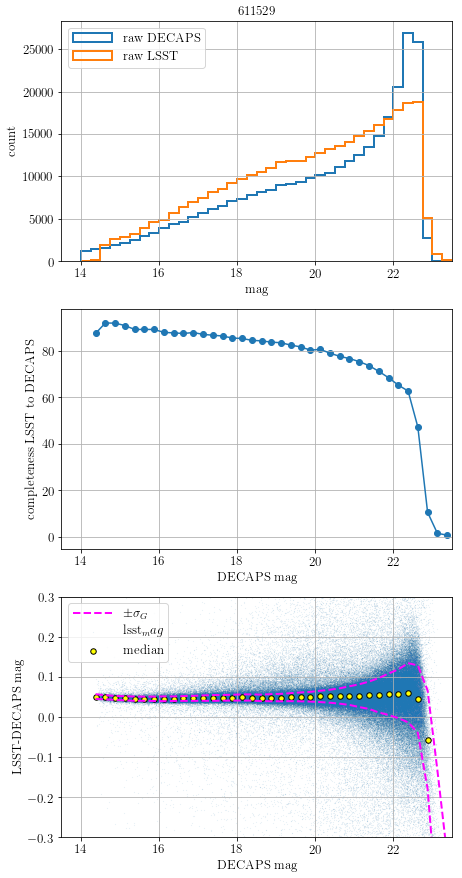

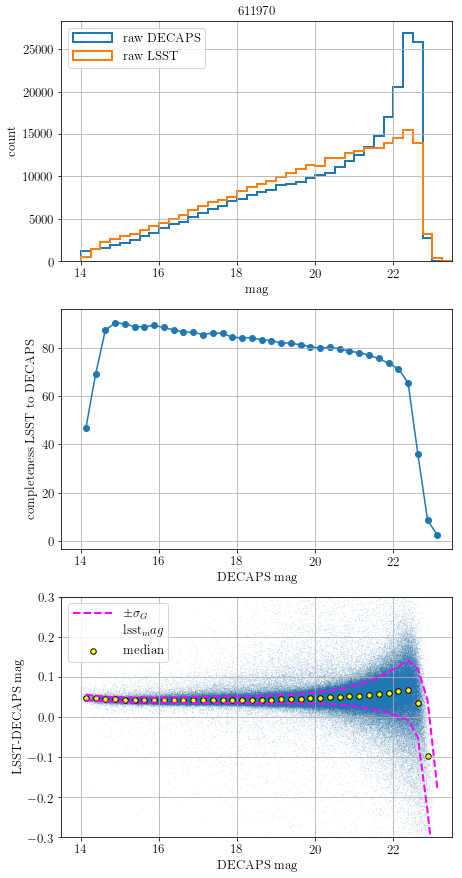

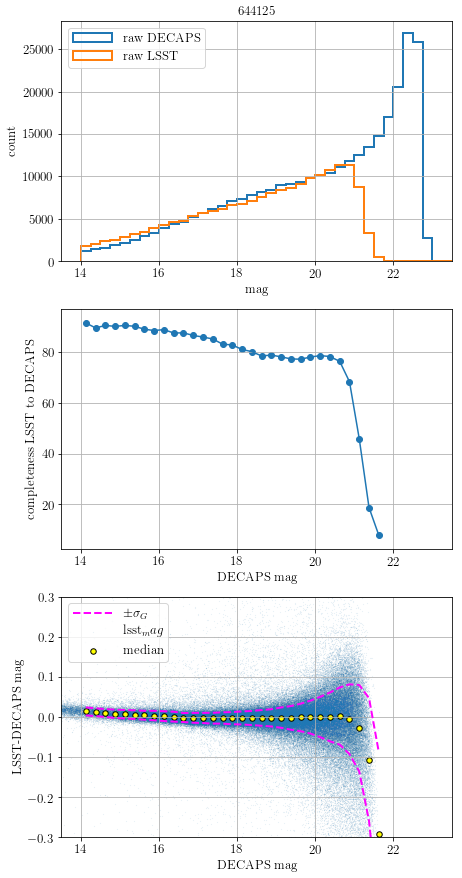

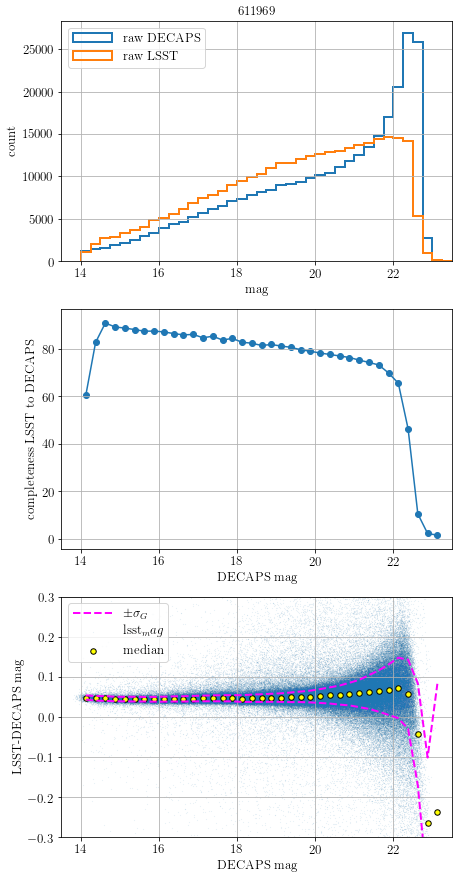

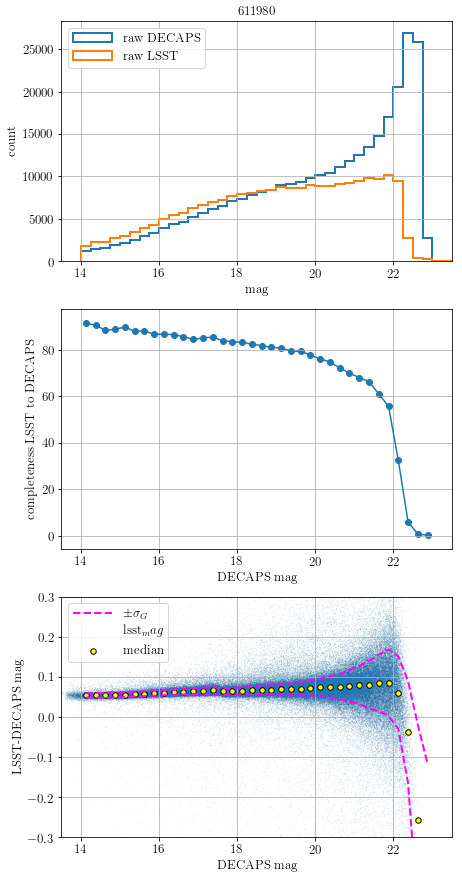

In [144]:
# plotting ....
for visit in visits :  
    
    # initialize the plottig space 
    fig,ax = plt.subplots(3,1,figsize=(7,15))
    bins = np.arange(14,24,0.25)
    
    # read in the clean DECAPS-LSST data 
    decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
    
    # read in the clean LSST data
    lsst_clean = Table.read('lsst_clean_'+str(visit)+'.txt', format='ascii')
    
    # plot raw counts for clean catalogs 
    plot_counts(decaps_clean,lsst_clean,visit, ax[0],bins)
    
    # plot completeness 
    plot_completeness(decaps_lsst, visit,ax[1],bins)
    
    # plot magnitude scatter
    plot_dmag(decaps_lsst,visit,ax[2],bins)
    for i in range(len(ax)):
        ax[i].set_xlim(13.5,23.5)
    plt.savefig('panels_'+str(visit)+'.png', bbox_inches='tight')

In [29]:

def multiplot_count(x,ax,bins,density,color='k',marker='*', step=False, normed=True):
    ''' Compute the count per bin using scipy
    binned statistic. More versatile than histogram. 
    
    Parameters :
    ----------------
    normed : if True,  then normalizing by the total
        number of counts within the histogram bounds 
        ( not including anything beyond the scale of 
        the plot)
    '''
    stat_count = bs(x,x,bins=bins, statistic='count')
    bin_centers = (bins[:-1] + bins[1:])/2
    count = stat_count.statistic 
    if normed : 
        count /= np.sum(count)
    if step : 
        ax.step(bin_centers, count, c=color, label=str(density))
    else : 
        ax.plot(bin_centers, count, c=color, marker=marker)
        #ax.scatter(bin_centers,count,c=color)
    
def multiplot_completeness(decaps_lsst, visit,ax,bins,density,color,marker):
    # Plot completeness for this single visit ...    
    #bins = np.arange(14,24,0.5)

    stat_decaps = bs(decaps_lsst['decaps_mag'], decaps_lsst['decaps_mag'] , 
                  bins = bins , statistic='count')
    decaps_count = stat_decaps.statistic

    stat_matched = bs(decaps_lsst['decaps_mag'], decaps_lsst['lsst_match'] , 
                        bins =bins , statistic=np.sum)
    lsst_matched_count = stat_matched.statistic
    completeness = 100 * (lsst_matched_count / decaps_count)

    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    ax.plot(bin_centers, completeness,c=color, marker=marker)
    #ax.scatter(bin_centers, completeness,c=color)


**One panel separation : color by MAF densities **

In [56]:
import matplotlib
cmap = matplotlib.cm.get_cmap('viridis')

N = len(densities)
i = 0 
fig,ax = plt.subplots(1,1,figsize=(8,6))
bins = np.linspace(0,0.3,50)
for density in densities : 
    visit = visit_density_dic[density]
    color = cmap((i+1)/N)
    decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
    x = decaps_lsst['d2darcsec']
    multiplot_count(x,ax,bins,density,color, step=True)
    i += 1
ax.set_xlabel('separation in arcsec')
ax.set_ylabel('count')
ax.grid()
ax.legend(fancybox=True, loc="upper right")
    
plt.savefig('decaps_lsst_separation_NEW.png', bbox_inches='tight')
plt.show()

NameError: name 'visit_density_dic' is not defined

**One panel separation : color by actual densities **

In [8]:
# Do the same, but color by the actual source count in the cleaned LSST catalog ..
visits_table_lsst = Table.read('visits_table_lsst.txt', format='latex')

In [13]:
visits_table_lsst.sort('N_clean')

In [20]:
#xmatched = np.array(['decaps-lsst-'+str(visit)+'.txt' for visit in visits])
#to_crossmatch = visits[~np.in1d(xmatched, os.listdir())]

In [38]:
# Read the separation ahead of time to 
# Save time when plotting 
d2d = {}
for visit in visits : 
    decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
    d2d[visit] = decaps_lsst['d2darcsec']

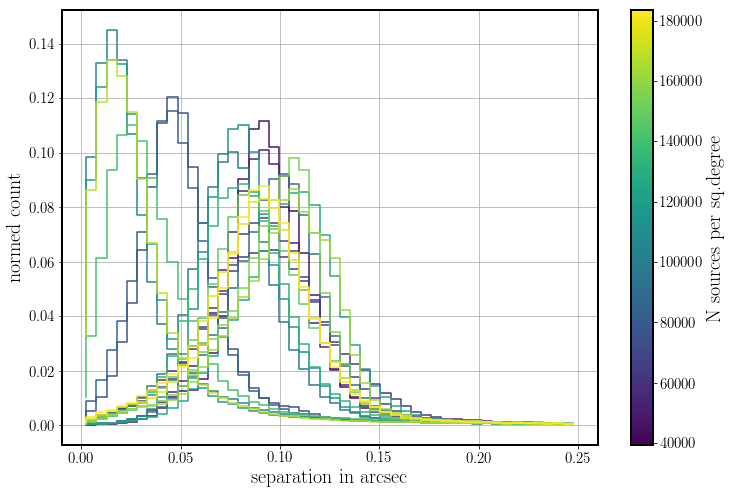

In [59]:
import matplotlib
cmap = matplotlib.cm.get_cmap('viridis')
visits  = visits_table_lsst['visit']
densities = visits_table_lsst['N_per_sq_deg']
N = len(densities)
from matplotlib import rcParams   
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
fig,ax = plt.subplots(1,1,figsize=(12,8))
bins = np.linspace(0,0.25,50)
i = 0 
x = {}
for visit in visits : 
    density = int(densities[i])
    color = cmap((i+1)/N)
    #decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
    #x = decaps_lsst['d2darcsec']
    x  = d2d[visit]
    multiplot_count(x,ax,bins,density,color, step=True)
    i += 1
ax.set_xlabel('separation in arcsec')
ax.set_ylabel('normed count')
ax.grid()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(densities), 
                                                         vmax=max(densities)))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
plt.colorbar(sm, ax=ax, label='N sources per sq.degree')    
plt.savefig('decaps_lsst_separation_N_p_sq_deg.png', bbox_inches='tight')
plt.show()

In [46]:
density

183642

**One panel completeness **

In [273]:
densities = list(visit_density_dic.keys())
densities

['20', '15', '10', '5']

20
    611529


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    609754


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525814


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525900


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


15
    611970


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525837


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525838


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


10
    611969


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525846


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525879


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


5
    525904


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525920


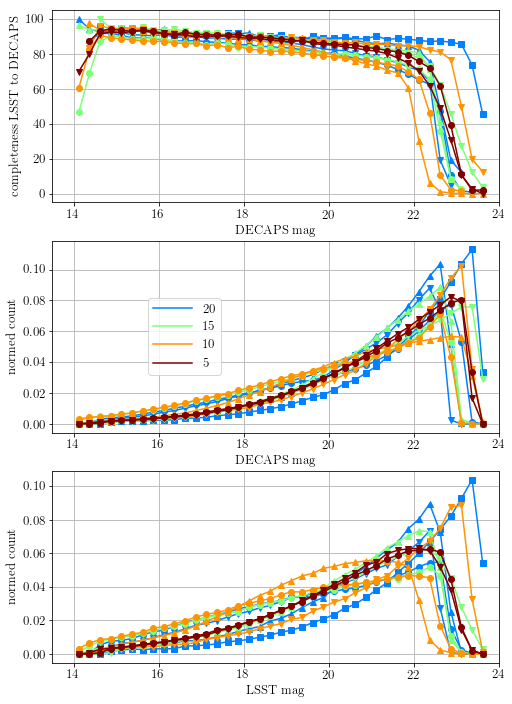

In [305]:
%matplotlib inline 
# Plot all visits on one panel... 

use_old = True 
if use_old :
    visit_density_dic = {'25g,t1' : 644125, '25g,t2':568172, '20g':611980,
                         '20r': 611529, '20i': 609754, '15':611970, 
                         '10':611969, '5':527064}
else : 
    visit_density_dic = {'25g1': 525951, '25g2': 525952, '20g1':525814,
                    '20g2':525900, '15g1':525837, '15g2':525838,
                    '10g1':525846, '10g2':525879, '5g1':525904,
                    '5g2':525920}

visit_density_dic = {'20':[611529,609754,525814,525900],
                     '15':[611970,525837,525838],
                     '10':[611969,525846,525879],
                     '5':[525904,525920]}    
    
ls = ['--', '']
# NEW : 
# 25% 525951, 525952
# 20% 525814, 525900 
# 15% 525837, 525838
# 10% 525846, 525879  
# 5%  525904, 525920

# OLD : all downloaded 
# 25% 644125 , 568172
# 20% 611980 , 611529 , 609754
# 15% 611970 
# 10% 611969 
# 5% 527064 


# Check if all files are present 
#visits = list(np.ravel(visit_density_dic.values()))
#decaps_lsst_files = [x for x in os.listdir() if x.startswith('decaps-lsst-')]
#decaps_sought = ['decaps-lsst-'+str(visit)+'.txt' for visit in visits]
#mask_needed = np.bitwise_not(np.in1d(decaps_sought, decaps_lsst_files))
#if np.sum(mask_needed) > 0 : 
#    print('Need to cross-match',np.array(decaps_sought)[mask_needed])

#else : # go ahead and plot only if files present 
fig,ax = plt.subplots(3,1,figsize=(8,12))
bins = np.arange(14,24,0.25)
import matplotlib
import matplotlib.lines as mlines
cmap = matplotlib.cm.get_cmap('jet')
densities = list(visit_density_dic.keys())
N = len(densities)
i = 0 
ax_legend_handles = []
markers = ['o','v', '^','s','D','*']
for density in densities : 
    print(density)
    visits = visit_density_dic[density]
    color = cmap((i+1)/N)
    
    # add a line to the density legend... 
    line = mlines.Line2D([], [], color=color, label=density+'%')
    ax_legend_handles.append(line)
    j = 0
    for visit in visits: 
        marker = markers[j]
        print('   ', visit)
        # reading the cross-matched  lsst-decaps data
        decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
        multiplot_completeness(decaps_lsst, visit,ax[0],bins,density, color,marker)

        # plot count of inout clean DECAPS
        multiplot_count(decaps_lsst['decaps_mag'],ax[1],bins,density,color,marker)

        # plot count of input clean LSST
        lsst_clean = Table.read('lsst_clean_'+str(visit)+'.txt', format='ascii')
        multiplot_count(lsst_clean['lsst_mag'],ax[2],bins,density,color,marker)
        j += 1 
    i += 1 

ax[0].set_xlabel('DECAPS mag ')
ax[0].set_ylabel('completeness LSST to DECAPS %')

ax[1].set_xlabel('DECAPS mag')
ax[1].set_ylabel('normed count')
ax[1].legend(bbox_to_anchor=(0.2,0.5),
             fancybox=True, loc="center left",
             handles = ax_legend_handles)

ax[2].set_xlabel('LSST mag')
ax[2].set_ylabel('normed count')

#plot_dmag(decaps_lsst,visit,ax[3],bins)
for i in range(len(ax)):
    ax[i].set_xlim(13.5,24)
    ax[i].grid()
plt.savefig('completeness_count_lsst_decaps.png', bbox_inches='tight')
plt.show()

** The same as above, but color by actual source densities **

i= 0     530012


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 1     525846


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 2     525900


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 3     529989


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 4     529974


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 5     525814


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 6     527247


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 7     527246


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 8     611970


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 9     527296


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 10     611969


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 11     525838


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 12     525837


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 13     611529


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 14     525920
i= 15     527300


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 16     525904


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 17     609754


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 18     530032


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


i= 19     525879


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


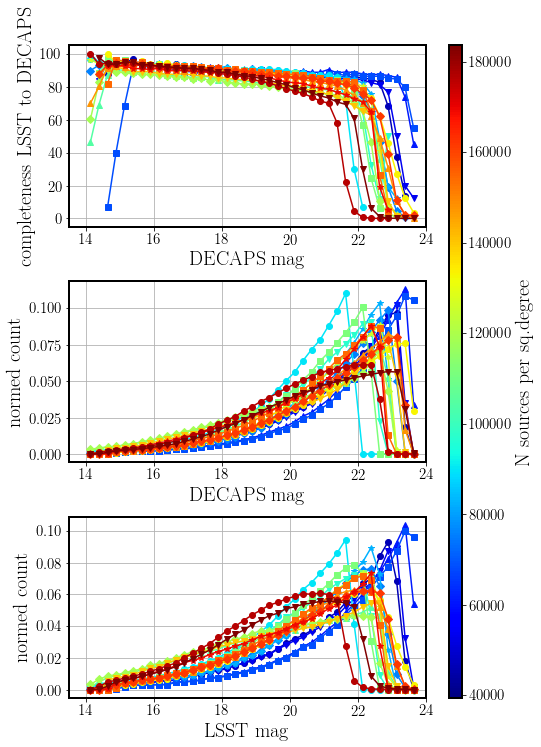

In [75]:
import matplotlib
import matplotlib.lines as mlines
cmap = matplotlib.cm.get_cmap('jet')

%matplotlib inline 

# Plot all visits on one panel... 
visits_table_lsst = Table.read('visits_table_lsst.txt', format='latex')
visits_table_lsst.sort('N_clean') # sort by source count  

ls = ['--', '']
visits  = visits_table_lsst['visit']
densities = visits_table_lsst['N_per_sq_deg']
N = len(densities)
fig,ax = plt.subplots(3,1,figsize=(8,12))
bins = np.arange(14,24,0.25)
i = 0 
ax_legend_handles = []
markers = ['o','v', '^','s','D','*','o','v', '^',
           's','D','*','o','v', '^','s','D','*',
          'o','v', '^','s','D','*']
for visit in visits : 
    density = int(densities[i])
    print('i=',i,'   ', visit)
    
    color = cmap((i+1)/N)
    marker = markers[i]
    
    # reading the cross-matched  lsst-decaps data
    decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
    multiplot_completeness(decaps_lsst, visit,ax[0],bins,density, color,marker)

    # plot count of inout clean DECAPS
    multiplot_count(decaps_lsst['decaps_mag'],ax[1],bins,density,color,marker)

    # plot count of input clean LSST
    lsst_clean = Table.read('lsst_clean_'+str(visit)+'.txt', format='ascii')
    multiplot_count(lsst_clean['lsst_mag'],ax[2],bins,density,color,marker)
    
    i += 1 

ax[0].set_xlabel('DECAPS mag ')
ax[0].set_ylabel('completeness LSST to DECAPS %')

ax[1].set_xlabel('DECAPS mag')
ax[1].set_ylabel('normed count')
fig.subplots_adjust(hspace=0.3)
# Make a quick mappable to get a nice colorbar ... 
# https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(densities), 
                                                      vmax=max(densities)))
sm._A = []
cax,kw = matplotlib.colorbar.make_axes([ax for ax in ax.flat],
                                      aspect=50)
plt.colorbar(sm, cax=cax,
             label='N sources per sq.degree') 
#fig.colorbar(sm, ax=ax.ravel().tolist(),
#             label='N sources per sq.degree')   

#ax[1].legend(bbox_to_anchor=(0.2,0.5),
#             fancybox=True, loc="center left",
#             handles = ax_legend_handles)

ax[2].set_xlabel('LSST mag')
ax[2].set_ylabel('normed count')

#plot_dmag(decaps_lsst,visit,ax[3],bins)
for i in range(len(ax)):
    ax[i].set_xlim(13.5,24)
    ax[i].grid()

plt.savefig('completeness_count_lsst_decaps_N_true.png', bbox_inches='tight')
plt.show()

In [69]:
matplotlib.colorbar.make_axes?

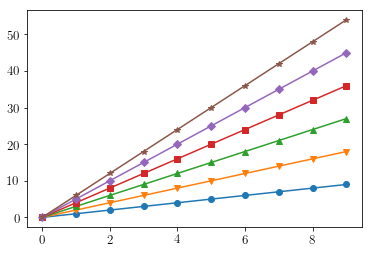

In [302]:
x = np.arange(10)
marker = ['o','v', '^','s','D','*']
for i in range(len(marker)):
    m  = marker[i]
    plt.plot(x,(i+1)*x,marker=m, label=m)
#plt.legend()

In [286]:
plt.plot?

In [169]:
#decaps_sought

In [168]:
#decaps_lsst_files

In [227]:
#type(decaps_lsst_files[6])

15 611970


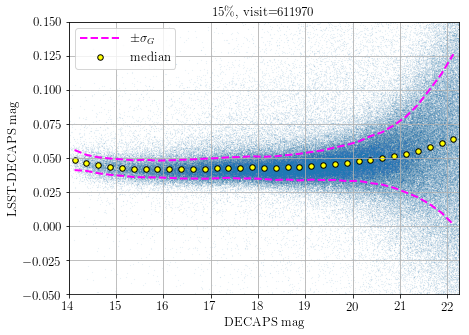

In [313]:
#RMS : LSST_DECAPS comparison of the photometric scatter 

def plot_dmag(decaps_lsst,visit,ax,bins):
    #bins = np.arange(14,23,0.5)
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    dm = y-x 
    
    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic

    # calculate the median per bin 
    median = bs(x,dm, bins=bins,statistic='median')
    med = median.statistic
    
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # plotting
    #fig,ax = plt.subplots(1,1)
    ax.scatter(x,y-x,s=0.001, label='')
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(-0.05, 0.15)
    ax.scatter(bin_centers , med ,s=30,c='yellow', edgecolors='k',
              label='median')
    ax.plot(bin_centers, med+sig, ls='--', lw=2, c='magenta', label=r'$\pm \sigma_{G}$')
    ax.plot(bin_centers, med-sig, ls='--', lw=2, c='magenta')
    ax.legend(loc='upper left')
    ax.set_xlabel('DECAPS mag')
    ax.set_ylabel('LSST-DECAPS mag')
    ax.grid()
    #ax.set_title(str(visit))
    #plt.savefig(str(visit)+'_half_arcsec_matches1.png', bbox_inches='tight')
    #plt.show()
bins = np.arange(14,22.5,0.25)
for density in ['15'] : # ['25'] : # : # ['25']:# densities : 
     #  ['25']:# in visits :# [611980] : #visits: 
    fig,ax= plt.subplots(1,1,figsize=(7,5))
    visit = visit_density_dic[density][0]
    print(density, visit) 
    decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
    plot_dmag(decaps_lsst,visit,ax,bins) 
    ax.set_title(density+'\%'+', visit='+str(visit))
    plt.savefig('decaps_lsst_dmag_density_'+density+'.png', bbox_inches='tight')
# We positionally cross match DECAPS and LSST catalogs, and plot the 
# magnitude difference for objects within 0.5 arcsec from each other. 
# The median and sigmaG are calculated on full sample, i.e. 
# no clip on magnitude difference. 

# For completeness we also assumed that a match has to be within 
# 0.5 magnitude , but this does not affect median and sigmaG 
# which are not sensitive to rare outliers (objects 
# that are spatially close, but have a magnitude difference larger 
# than 0.5 magnitudes  )

In [309]:
a = density+'%'+'visit='+str(visit)
print(a)

15%visit=611970


In [229]:
#len(bin_edges[:-1])


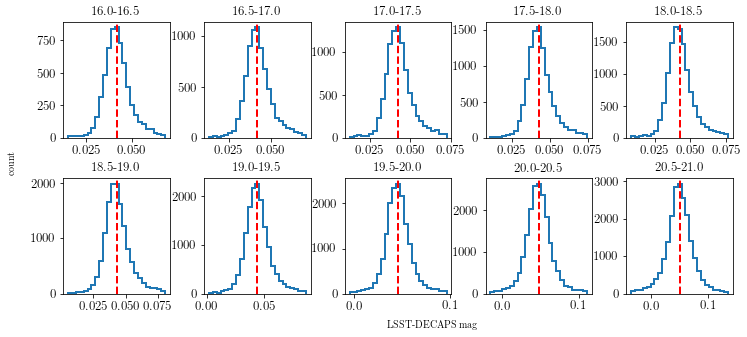

In [314]:
# Make a plot per visit with three panels, corresponding to three 
# magnitude bins ...
bin_edges = np.arange(16,21.5,0.5)
rows = 2 
cols = 5
assert len(bin_edges[:-1]) == rows*cols
fig,axes = plt.subplots(2,5,figsize=(12,5))
axs = np.ravel(axes)
i= 0 
for ax in axs : 
    mag_min = bin_edges[i]
    mag_max = bin_edges[i+1]
    
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    dm = y-x 
    mask_mag = (mag_min<x)*(x<mag_max)
    dm_bin = dm[mask_mag]
    med = np.median(dm_bin)
    sigG = sigmaG(dm_bin)
    ax.hist(dm_bin, histtype='step', lw=2, range=(med-4*sigG, med+4*sigG), bins=25)
    ax.axvline(med,ls='--', c='red', lw=2)
    ax.set_title(str(mag_min)+'-'+str(mag_max),fontweight='bold')
    i += 1 

fig.subplots_adjust(hspace=0.35, wspace=0.32
                   )
fig.text(0.5,0.03, 'LSST-DECAPS mag')
fig.text(0.06, 0.5, 'count', rotation='vertical')
plt.savefig('rms_decaps_lsst_'+str(visit)+'hist_panel.png', bbox_inches='tight')

# We plot histograms of magnitude difference in bins of decaps magnitude. 
# The limits on each histogram are +/- 4 sigmaG  from the median,
# with both sigmaG and median calcualated based on unclipped magnitude difference


20
    611529
    609754
    525814
    525900
15
    611970
    525837
    525838
10
    611969
    525846
    525879
5
    525904
    525920


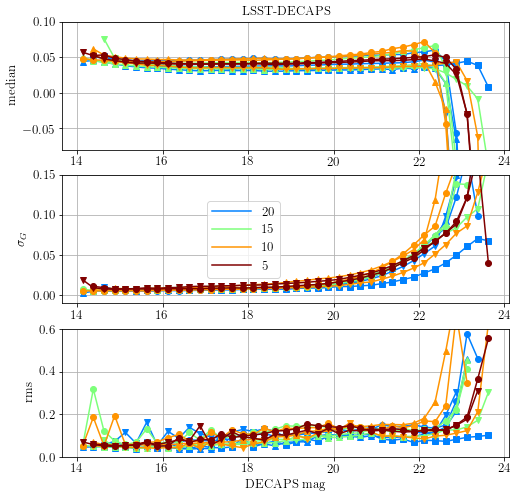

In [321]:
def plot_dmag_stats(decaps_lsst,visit,ax,bins, density,color,marker):
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    dm = y-x 
    
    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic
    
    # calculate the spread : rms
    rms_func = lambda x : np.sqrt(np.mean(np.square(x)))
    spread_rms = bs(x,dm, bins=bins,statistic=rms_func)
    rms = spread_rms.statistic

    # calculate the median per bin 
    median = bs(x,dm, bins=bins,statistic='median')
    med = median.statistic
    
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # plotting
    #ax[0].scatter(bin_centers , med ,s=30, c=color)
    ax[0].plot(bin_centers , med, label=density, marker=marker, c=color)

    #ax[1].scatter(bin_centers,sig)
    ax[1].plot(bin_centers,sig,label=density,marker=marker, c=color)
    
    #ax[2].scatter(bin_centers, rms)
    ax[2].plot(bin_centers, rms, label=density,marker=marker, c=color)
    
visit_density_dic = {'20':[611529,609754,525814,525900],
                     '15':[611970,525837,525838],
                     '10':[611969,525846,525879],
                     '5':[525904,525920]}    

# Plot all visits on one panel : 
fig, ax=  plt.subplots(3,1, figsize=(8,8))
bins = np.arange(14,24,0.25)
cmap = matplotlib.cm.get_cmap('jet')
densities = list(visit_density_dic.keys())
N = len(densities)
i = 0 
ax_legend_handles = []
markers = ['o','v', '^','s','D','*']
for density in densities : 
    print(density)
    visits = visit_density_dic[density]
    color = cmap((i+1)/N)
    
    # add a line to the density legend... 
    line = mlines.Line2D([], [], color=color, label=density+'%')
    ax_legend_handles.append(line)
    j = 0
    for visit in visits: 
        marker = markers[j]
        print('   ', visit)
        decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
        plot_dmag_stats(decaps_lsst, visit, ax, bins, density, color, marker)
        j += 1 
    i += 1 
    
ax[0].set_title('LSST-DECAPS')
ax[0].set_ylabel('median')
ax[0].set_ylim(-0.08, 0.1)


ax[1].set_ylabel(r'$\sigma_{G}$')
ax[1].set_ylim(-0.01,0.15)

ax[2].set_ylabel('rms')
ax[2].set_ylim(0,0.6)


ax[2].set_xlabel('DECAPS mag')

# put the legend outside the plot 
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
for i in range(len(ax)):
    ax[i].grid()

ax[1].legend(handles = ax_legend_handles,
             bbox_to_anchor=(0.31,0.5),
              fancybox=True, loc="center left")
   

# one panel with sigmaG
# one panel with medians
# one panel with rms 

plt.savefig('decaps_lsst_rms_plot.png', bbox_inches='tight')


In [185]:
#densities

## Compare zeropoints 

In [83]:
################################
########### ASIDE ##############
################################


# Since it looks like the problem lies in zeropoints, 
# compare the zero points : 


visits = {611529, 611970, 644125, 611969, 611980}

zeropoints = {'decaps_single':[],'lsst_single':[], 'decaps_calib':[], 
               'visit':[]}

for visit in visits : 
    zeropoints['visit'].append(visit)
    cat_name = imdb[imdb['expnum'] == visit]['catfname'].data[0]
    singleDir = '../raw_data/decaps_catalogs/single_epoch/'
    file_name  = singleDir + cat_name
    decaps_hdu = fits.open(file_name)
    # obtain the calibrated decaps zeropoint, 
    # based on the observation date ... 
    mjd_obs = decaps_hdu[0].header['MJD-OBS']
    m = zps_table['mjd_obs'] == mjd_obs
    decaps_calibrated_zpt = zps_table['zp'][m].data[0]
    zeropoints['decaps_calib'].append(decaps_calibrated_zpt)

    # use the single-epoch decaps zeropoint 
    decaps_single_zpt = decaps_hdu[0].header['MAGZERO']  
    zeropoints['decaps_single'].append(decaps_single_zpt)

    outDir = '../data_products/LSST_Stack_processing/DECam/'+str(visit)+'/'
    # first check calexp for zero point magnitude
    calexp_files = os.listdir(outDir+'calexp/')
    calexp_hdu = fits.open(outDir+'calexp/' + calexp_files[0])
    lsst_zeropoint = calexp_hdu[0].header['MAGZERO']
    zeropoints['lsst_single'].append(lsst_zeropoint)

zpts_table = Table(zeropoints)

In [85]:
zpts_table.write('zeropoints.txt', format='ascii')

In [41]:
################################
########### ASIDE ##############
################################
# Clean using the LSST mask information ... 
hdu = fits.open('src-0'+str(visit)+'_10.fits')
ccd_data = Table(hdu[1].data)
flag_count = len(ccd_data['flags'][0])
flag_dictionary = {'index':[],
                   'flag_number':[],
                  'flag_name':[],
                  'flag_doc':[]
                  }
for flag_number in range(1,1+flag_count):
    flag_dictionary['index'].append(flag_number-1)
    flag_dictionary['flag_number'].append(flag_number)
    flag_dictionary['flag_doc'].append(hdu[1].header['TFDOC'+str(flag_number)])
    flag_dictionary['flag_name'].append(hdu[1].header['TFLAG'+str(flag_number)])
Table(flag_dictionary).write(str(visit)+'_flag_dict.dat', format='ascii',
                            overwrite='True')

# It may be too cumbersome to use the FITS-compressed mask data to 
# clean the LSST dictionary ...
# In a way , since we are matching LSST to DECAPS, 
# all the bad sources in the LSST catalog don't matter as much 
#table(table(tabl# since they simply wouldn't have a good match  anyway . Table(flag_dictionary)

In [34]:
len(Table(flag_dictionary))

83

In [42]:
Table(flag_dictionary)[58:74]

index,flag_number,flag_name,flag_doc
int64,int64,str54,str106
58,59,base_GaussianFlux_flag,General Failure Flag
59,60,base_PixelFlags_flag,"general failure flag, set if anything went wring"
60,61,base_PixelFlags_flag_offimage,Source center is off image
61,62,base_PixelFlags_flag_edge,Source is outside usable exposure region (masked EDGE or NO_DATA)
62,63,base_PixelFlags_flag_interpolated,Interpolated pixel in the Source footprint
63,64,base_PixelFlags_flag_saturated,Saturated pixel in the Source footprint
64,65,base_PixelFlags_flag_cr,Cosmic ray in the Source footprint
65,66,base_PixelFlags_flag_bad,Bad pixel in the Source footprint
66,67,base_PixelFlags_flag_suspect,Source's footprint includes suspect pixels


In [39]:
ccd_data[0]['flags'][0]

True